Este Práctico fue realizado por Quiros Agustina, Porcel Carolina y Peralta Agustín

In [3]:
import gzip
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import bz2
import mlflow
from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange

Cargamos el Dataset de entrenamiento

In [4]:
dataset_train = pd.read_json("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.train.jsonl",lines=True, orient='records')

Cargamos el dataset de validacion, con el que vamos a optimizar hiperparametros

In [5]:
dataset_test = pd.read_json("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.validation.jsonl",lines=True, orient='records')

Cargamos el dataset de test, con el que vamos a probar nuestro modelo

In [6]:
dataset_val = pd.read_json("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.test.jsonl",lines=True, orient='records')

Creamos nuestro dataset que concatena el train y validacion para poder tener todo nuestro vocabulario en este Dataset

In [7]:
dataset = pd.concat([dataset_train,dataset_test,dataset_val])

Análisis descriptivo del dataset de train

In [8]:
dataset_train.title.nunique() #Hay 4895280 títulos diferentes en el dataset

4895280

In [9]:
dataset_train.category.nunique() # Hay 632 categorías diferentes

632

In [10]:
dataset_train.category.value_counts() # Distribución de las categorías.

BOOKS                            15208
ACTION_FIGURES                   14746
MAGAZINES                        14465
DIECAST_VEHICLES                 14338
FOOTBALL_SHIRTS                  14338
                                 ...  
COIL_BINDING_MACHINES              714
TANDEM_CHAIRS                      687
INDUSTRIAL_ICE_CREAM_MACHINES      550
SCREEN_PRINTING_FRAMES             386
MOTORCYCLE_EXHAUSTS                220
Name: category, Length: 632, dtype: int64

Creamos la clase que nos permite manejar el DataSet 

In [11]:
class MelichanllegeDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

# dataset = MelichanllegeDataset("/users/aperalta/Practicos/Practico_1/meli-challenge-2019/spanish.train.jsonl")
# print(f"Dataset loaded with {len(dataset)} elements")
# print(f"Sample element:\n{dataset[0]}")

Creamos la clase que nos permite limpiar y pre-procesar nuestros datos. Tranformaciones y normalización

In [12]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

Instanciamos nuestro preprocess

In [13]:
preprocess = RawDataProcessor(dataset)

In [14]:
Instanciamos nuestros Datasets de pytorch. Mediante la clase que creamos anteriormente

SyntaxError: invalid syntax (3140449297.py, line 1)

In [15]:
train_dataset = MelichanllegeDataset(dataset_train, transform=preprocess)

In [16]:
test_dataset = MelichanllegeDataset(dataset_test, transform=preprocess)

In [17]:
val_dataset = MelichanllegeDataset(dataset_val, transform=preprocess)

In [18]:
print(f"Datasets loaded with {len(train_dataset)} training elements and {len(train_dataset)} test elements")
print(f"Sample train element:\n{train_dataset[0]}")

Datasets loaded with 4895280 training elements and 4895280 test elements
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}


In [19]:
print(f"Datasets loaded with {len(test_dataset)} training elements and {len(test_dataset)} test elements")
print(f"Sample train element:\n{test_dataset[0]}")

Datasets loaded with 1223820 training elements and 1223820 test elements
Sample train element:
{'data': [463, 1484, 3457], 'target': 216}


Como en este caso trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un batch de datos, el DataLoader de PyTorch espera que los datos del batch tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija). Esto lo podemos lograr mediante el parámetro de collate_fn. En particular, esta función se encarga de tomar varios elementos de un Dataset y combinarlos de manera que puedan ser devueltos como un tensor de PyTorch.

In [20]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

Ya habiendo definido nuestros conjuntos de datos y nuestra collation_fn, podemos definir nuestros DataLoader, uno para entrenamiento, otro para evaluación (Ajuste hiperparametros) y el último para test.

In [21]:
pad_sequences = PadSequences()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers = 0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers = 0)

In [ ]:
# class DeepLearningClassifier(nn.Module):
#     def __init__(self, 
#                  pretrained_embeddings_path, 
#                  dictionary,
#                  vector_size,
#                  freeze_embedings):
#         super().__init__()
#         embeddings_matrix = torch.randn(len(dictionary), vector_size)
#         embeddings_matrix[0] = torch.zeros(vector_size)
#         with gzip.open(pretrained_embeddings_path, "rt") as fh:
#             for line in fh:
#                 word, vector = line.strip().split(None, 1)
#                 if word in dictionary.token2id:
#                     embeddings_matrix[dictionary.token2id[word]] =\
#                         torch.FloatTensor([float(n) for n in vector.split()])
#         self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
#                                                        freeze=freeze_embedings,
#                                                        padding_idx=0)
#         self.hidden1 = nn.Linear(vector_size, 128)
#         self.hidden2 = nn.Linear(128, 128)
#         self.output = nn.Linear(128, 1)
#         self.vector_size = vector_size
    
#     def forward(self, x):
#         x = self.embeddings(x)
#         x = torch.mean(x, dim=1)
#         x = F.relu(self.hidden1(x))
#         x = F.relu(self.hidden2(x))
#         x = torch.sigmoid(self.output(x))
#         return x

Creamos nuestra clase donde definimos nuestro modelo. Usamos un embeding pre-entrenado y 4 capas ocultas y una capa de salida de 632 neuronas (Salida Final). No aplicamos función de activación ya que vamos a utilizar Cross Entropy Loss cómo función de pérdida y ya incorpora una activación softmax

In [22]:
class MLP(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden_layer1 = nn.Linear(vector_size, 1024)
        self.hidden_layer2 = nn.Linear(1024, 2048)
        self.hidden_layer3 = nn.Linear(2048, 728)
        self.hidden_layer4 = nn.Linear(728, 512)
        self.output_layer = nn.Linear(512, 632)
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = self.hidden_layer1(x)  # Go through hidden layer 1
        x = F.relu(x)  # Activation Function layer 1
        x = self.hidden_layer2(x) # Go through hidden layer 2
        x = F.relu(x)  # Activation Function layer 2
        x = self.hidden_layer3(x)
        x = F.relu(x)
        x = self.hidden_layer4(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x


In [ ]:
# def train_and_eval(model, optimizer, loss_function, trainloader, epochs,
#                    valloader, use_tqdm=True):
#     history = {'train_loss': [], 'val_loss': [], 'val_b_accuracy': []}
#     for epoch in range(epochs):  # loop over the dataset multiple times
#         model.train()
#         running_loss = 0.0
#         pbar = tqdm(trainloader) if use_tqdm else trainloader
#         for step, data in enumerate(pbar, 1):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs = data["data"].to(device)
#             labels = data["target"].to(device)
#             # zero the parameter gradients
#             optimizer.zero_grad()
#             # forward + backward + optimize
#             outputs = model(inputs)
#             loss = loss_function(outputs, labels.squeeze().long())
#             loss.backward()
#             optimizer.step()

#             # print statistics
#             running_loss += loss.item()
#             if use_tqdm and step > 0 and step % 50 == 0:
#                 pbar.set_description(
#                     f"[{epoch + 1}, {step}] loss: {running_loss / step:.4g}")
#         history['train_loss'].append((epoch, running_loss / step))

#         # At the end of the epoch, evaluate model on validation
#         model.eval();  # Activate evaluation mode
#         running_loss = 0.0
#         y_true = []
#         y_pred = []
#         with torch.no_grad():
#             pbar = tqdm(valloader) if use_tqdm else valloader
#             for step, data in enumerate(pbar, 1):
#                 inputs = data["data"].to(device)
#                 labels = data["target"].to(device)
#                 outputs = model(inputs)
#                 running_loss += loss_function(outputs, labels.squeeze().long()).item()
#                 _, predicted = torch.max(outputs.data, 1)
#                 y_true.extend(labels.cpu().numpy())
#                 y_pred.extend(predicted.cpu().numpy())
#         history['val_b_accuracy'].append(metrics.balanced_accuracy_score(y_true, y_pred))
#         history['val_loss'].append((epoch, running_loss / step))
    
#     return history

In [ ]:
# def run_experiment3(model, epochs, trainloader, testloader,
#                     optimizer_class=optim.SGD, lr=0.001, weight_decay=0.0,
#                     use_tqdm=True):
#     loss_function = nn.CrossEntropyLoss()
#     optimizer = optimizer_class(model.parameters(), lr=lr,
#                                 weight_decay=weight_decay)
#     history = train_and_eval(
#         model, optimizer, loss_function, trainloader, epochs,
#         valloader=testloader, use_tqdm=use_tqdm)
#     #test_results = eval(model, testloader, use_tqdm=use_tqdm)

#     experiment = {
#         'arquitecture': str(model), 'loss': str(loss_function),
#         'epochs': epochs, 'lr': lr, 'optimizer': str(optimizer_class),
#         'weight_decay': weight_decay
#     }
#     experiment.update(history)
#     #experiment.update(test_results)
#     return experiment

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
use_tqdm=True

Corremos nuestro modelo utilizando mlflow para trackear las corridas y los resultados.

In [25]:
mlflow.set_experiment("a_naive_experiment")

with mlflow.start_run():
    mlflow.log_param("model_name", "relu_test")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": 1024,
        "hidden2_size": 2048,
        "hidden3_size": 728,
        "hidden4_size": 512
    })
    history = {'train_loss': [], 'val_loss': [], 'val_b_accuracy': [], 'test_b_accuracy':[], 'test_f1':[]}
    model = MLP("/users/aperalta/Practicos/Practico_1/data/SBW-vectors-300-min5.txt.bz2", preprocess.dictionary,300, True)
    model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
    for epoch in trange(4):
        model.train()
        running_loss = []
        print_running_loss = 0.0
        pbar = tqdm(train_loader) if use_tqdm else train_loader
        for step, data in enumerate(pbar, 1):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels.squeeze().long())
            loss.backward()
            optimizer.step()
            
            # print statistics
            print_running_loss += loss.item()
            if use_tqdm and step > 0 and step % 50 == 0:
                pbar.set_description(
                    f"[{epoch + 1}, {step}] loss: {print_running_loss / step:.4g}")
            running_loss.append(loss.item())        
        history['train_loss'].append((epoch, print_running_loss / step))
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        
        
        model.eval()
        running_loss = []
        print_running_loss=0.0
        y_true = []
        y_pred = []
        pbar = tqdm(test_loader) if use_tqdm else test_loader
        for step, data in enumerate(pbar, 1):
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            outputs = model(inputs)
            running_loss.append(
                loss_function(outputs, labels.squeeze().long()).item()
            )
            print_running_loss += loss_function(outputs, labels.squeeze().long()).item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("test_avp", balanced_accuracy_score(y_true, y_pred), epoch)
        history['val_b_accuracy'].append((epoch,metrics.balanced_accuracy_score(y_true, y_pred)))
        history['val_loss'].append((epoch, print_running_loss / step))
        
    model.eval();
    with tempfile.TemporaryDirectory() as tmpdirname:
        y_true = []
        y_pred = []
        with torch.no_grad():
          pbar = tqdm(val_loader) if use_tqdm else val_loader
          for data in pbar:
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        history['test_b_accuracy'].append(metrics.balanced_accuracy_score(y_true, y_pred))
        history['test_f1'].append(metrics.f1_score(y_true, y_pred, average='macro'))
        pd.DataFrame({"prediction": y_pred, "target": y_true}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False)
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/76489 [00:00<?, ?it/s]

  0%|          | 0/19123 [00:00<?, ?it/s]

  0%|          | 0/995 [00:00<?, ?it/s]

In [26]:
history

{'train_loss': [(0, 2.0531646611312926),
  (1, 1.6248006588039108),
  (2, 1.5412634584334983),
  (3, 1.482550941276473)],
 'val_loss': [(0, 1.684523067931678),
  (1, 1.5980902977433096),
  (2, 1.5498126811520647),
  (3, 1.507259186161479)],
 'val_b_accuracy': [(0, 0.6118149439994095),
  (1, 0.6313820024688223),
  (2, 0.6448056084453361),
  (3, 0.65496604080008)],
 'test_b_accuracy': [0.7135724264114542],
 'test_f1': [0.7162293956457082]}

In [27]:
import seaborn

In [28]:
history['train_loss']

[(0, 2.0531646611312926),
 (1, 1.6248006588039108),
 (2, 1.5412634584334983),
 (3, 1.482550941276473)]

<AxesSubplot:xlabel='epoch', ylabel='loss'>

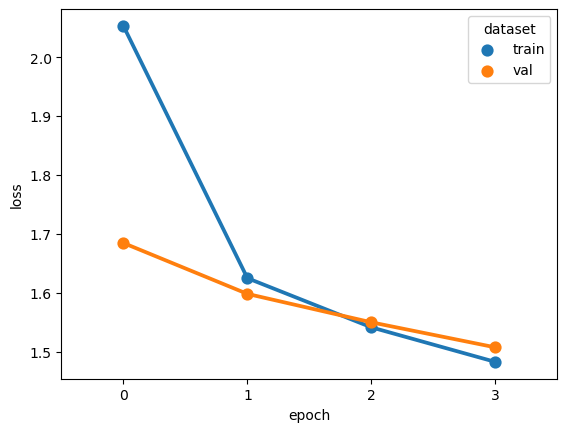

In [29]:
data = []
for epoch, (train_loss, val_loss) in enumerate(zip(
        history['train_loss'], history['val_loss'])):
    data.append((epoch, 'train', train_loss[1]))
    data.append((epoch, 'val', val_loss[1]))
data = pd.DataFrame(data=data, columns=['epoch', 'dataset', 'loss'])
seaborn.pointplot(
    data=data, x='epoch', y='loss', hue='dataset'
)

<AxesSubplot:xlabel='epoch', ylabel='val_b_accuracy'>

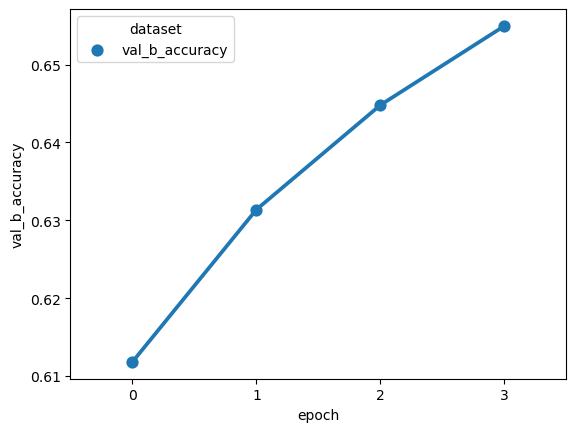

In [30]:
data = []
for epoch, val_b_accuracy in history['val_b_accuracy']:
    data.append((epoch,'val_b_accuracy',val_b_accuracy))
data = pd.DataFrame(data=data, columns=['epoch', 'dataset', 'val_b_accuracy'])
seaborn.pointplot(
    data=data, x='epoch', y='val_b_accuracy', hue='dataset'
)

Durante este práctico pudimos poner en práctico un modelo de perceptrón multicapa. Construímos un dataset que concatena los datasets de entranamiento, validación y test para armar nuestro preprocess y crear nuestro vocabulario para el modelo.

Definimos un batch size de 64 para poder acelerar un poco nuestro proceso de entrenamiento, ya que al empezar por algunos problemas técnicos y hasta que aprendimos sólo entrenabamos en CPU no en GPU.

A la hora de definir nuestro modelo, optamos por utilizar un embedding pre-entrenado que fue recomendación del profe. Y luego definimos el modelo con "embedding_size": 300,"hidden1_size": 1024,"hidden2_size": 2048,"hidden3_size": 728,"hidden4_size": 512. Usamos funciones de activación relu (Ya que probamos con una gelu anteriormente pero la performance fue levemente mejor con relu, se pueden ver los resultado en el experimento 8bf3a34045714850ab5f74e8d58d96c4 de la carpeta de mlflow), a la salida de la red no utilizamos una función de activación ya que al usar cómo loss una cross entropy loss entendemos ya que esta ya implementa una softmax por defecto. En este punto es importante notar que probamos con funciones de activación a la salida cómo tanh, softmax y sigmoide y en todos los casos obteniamos un accuracy del 1%, recién cuando sacamos la activación en la salida empezamos a mejorar nuestras metricas y avanzamos. En cuanto al optimizador probamos con Adagrad en primer momento, pero no obtuvimos mejores resultados comparandolo contra Adam, por eso elegimos este optimizador, nuestro primer intento fue con SDG. Probamos regularización mediante weight decay pero no obtuvimos mejoras, y luego viendo el gráfico de la loss entendimos que no estamos en overfitting

A futuro entendemos que nuestro accuracy puede mejorar, podríamos probar con modificar nuestra estructura de red y algunos parámetros.

In [31]:
dataset_val

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...,DIAPER_BAGS,test,"[mochilas, maternales, bolsos, bebe, simil, cu...","[5650, 5271, 5268, 915, 2724, 375, 37363]",318,632,63680
1,spanish,reliable,Bolso Maternal/bebe Incluye Cambiador + Correa...,DIAPER_BAGS,test,"[bolso, maternal, bebe, incluye, cambiador, co...","[502, 2742, 915, 3031, 2740, 1840, 4635]",318,632,63680
2,spanish,reliable,Mochila Maternal Land + Gancho Envio Gratis-cc,DIAPER_BAGS,test,"[mochila, maternal, land, gancho, envio, gratis]","[337, 2742, 2741, 3303, 211, 1429]",318,632,63680
3,spanish,reliable,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS,test,"[bolso, maternal, moderno, cambiador, correa, ...","[502, 2742, 2983, 2740, 1840, 476, 2990]",318,632,63680
4,spanish,reliable,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS,test,"[bolso, maternal, moderno, cambiador, correa, ...","[502, 2742, 2983, 2740, 1840, 4635]",318,632,63680
...,...,...,...,...,...,...,...,...,...,...
63675,spanish,reliable,Gimnasio Gym Manta Bebe Tiny Love Musica Luz M...,BABY_GYMS,test,"[gimnasio, gym, manta, bebe, tiny, love, music...","[1305, 1525, 2620, 915, 1308, 49, 5545, 587, 5...",258,632,63680
63676,spanish,reliable,Gimnasio Manta Con Actividades Para Bebe 846 Ath,BABY_GYMS,test,"[gimnasio, manta, actividades, bebe, ath]","[1305, 2620, 4625, 915, 6484]",258,632,63680
63677,spanish,reliable,Gimnasio Bebe Manta Didactica Tiny Love Kick A...,BABY_GYMS,test,"[gimnasio, bebe, manta, didactica, tiny, love,...","[1305, 915, 2620, 9537, 1308, 49, 6872, 1512, ...",258,632,63680
63678,spanish,reliable,Gimnasio Manta Alfombra Didactica Fitchbaby Ju...,BABY_GYMS,test,"[gimnasio, manta, alfombra, didactica, fitchba...","[1305, 2620, 794, 9537, 1, 282, 9424]",258,632,63680


In [32]:
print(f"Datasets loaded with {len(val_dataset)} training elements and {len(val_dataset)} test elements")
print(f"Sample train element:\n{val_dataset[63676]}")

Datasets loaded with 63680 training elements and 63680 test elements
Sample train element:
{'data': [1309, 2624, 4629, 155, 922, 6483], 'target': 48}


In [33]:
type(val_dataset)

__main__.MelichanllegeDataset

In [34]:
model.eval();
with tempfile.TemporaryDirectory() as tmpdirname:
        y_true = []
        y_pred = []
        with torch.no_grad():
          pbar = tqdm(val_loader) if use_tqdm else val_loader
          for data in pbar:
            inputs = data["data"].to(device)
            labels = data["target"].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        history['test_b_accuracy'].append(metrics.balanced_accuracy_score(y_true, y_pred))
        history['test_f1'].append(metrics.f1_score(y_true, y_pred, average='macro'))
        df_test=pd.DataFrame({"prediction": y_pred, "target": y_true})

  0%|          | 0/995 [00:00<?, ?it/s]

In [35]:
df_test['correct'] = df_test['prediction']==df_test['target']

In [36]:
df_fail=df_test[df_test['correct']==False]

In [37]:
df_fail['prediction'].value_counts()

87     229
354    210
90     200
392    164
203    132
      ... 
212      1
31       1
180      1
280      1
275      1
Name: prediction, Length: 620, dtype: int64

Distribución de errores por clases.